In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPool1D, Dropout, Dense, Reshape
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from keras import metrics
import pickle
%matplotlib inline

%load_ext autoreload
%autoreload 2
import helper

Using TensorFlow backend.


Fasttext facebook
PubMed PMC word vectors
Gensim word2vec

In [2]:
documents_train, target_train = helper.load_multiclass_data()

In [20]:
documents_test, ids_test = helper.load_binary_data("data/test_binary.csv")

# TfIdf-BoW model

In [3]:
count_vect = CountVectorizer(binary=False, max_df=0.9, min_df=3, lowercase=True, strip_accents="unicode")
count_vect.fit(documents_train)
pickle.dump(count_vect, open("models/valentin/vectorizer.p", "wb"))
X_train_counts = count_vect.transform(documents_train)
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_train_counts)
X.shape

(45587, 33714)

# Basic Keras model

In [46]:
from keras.layers import Dense, Dropout

In [14]:
def create_model():
    model = Sequential()
    model.add(Dense(16, input_shape=(X.shape[1],), activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [51]:
acc = []
for i in range(10):
    print("Loop {}".format(str(i)))
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.1)
    model = create_model()
    model.fit(X_train.todense(), y_train, validation_split=0.1, epochs=20, verbose=0)
    yhat = model.predict(X_test.todense())
    acc_i = helper.score_prediction(y_test, yhat, acc_only=True)
    acc.append(acc_i)

print("Average Accuracy: {:.2%}".format(np.mean(acc)))
print(acc)

Loop 0
Loop 1
Loop 2
Loop 3
Loop 4
Loop 5
Loop 6
Loop 7
Loop 8
Loop 9
Average Accuracy: 95.69%
[0.96759259259259256, 0.95833333333333337, 0.96296296296296291, 0.95370370370370372, 0.94907407407407407, 0.96759259259259256, 0.97222222222222221, 0.94907407407407407, 0.93055555555555558, 0.95833333333333337]


             precision    recall  f1-score   support

          0       0.95      1.00      0.98       103
          1       1.00      0.96      0.98       113

avg / total       0.98      0.98      0.98       216

Accuracy: 97.69%
AUC: 1.0


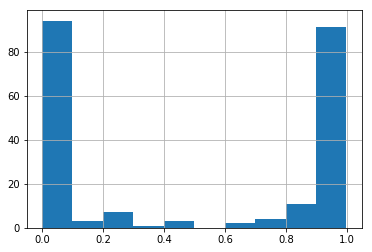

In [22]:
yhat = model.predict(X_test.todense())
helper.score_prediction(y_test, yhat)

## Full model

In [10]:
X_submission = count_vect.transform(documents_test)

In [17]:
model = create_model()
model.fit(X.todense(), target_train.values, epochs=20, verbose=1)
model.evaluate(X.todense(), target_train.values)
yhat = model.predict(X_submission.todense())

In [41]:
helper.create_binary_submission(yhat, ids_test, "submissions/valentin/")

# CNN with embedding layer

In [3]:
documents_train, target_train = helper.load_multiclass_data()

In [4]:
stoplist = list(gensim.parsing.preprocessing.STOPWORDS) + ["<span"] + list(range(0,9))
def word_is_valid(word):
    return word not in stoplist and len(word) > 2 and len(word) < 20

texts = [[word for word in document.lower().split() if word_is_valid(word)] for document in documents_train]

In [5]:
dictionary = gensim.corpora.Dictionary(texts)
print(dictionary)
dictionary.filter_extremes(no_above=0.9)
print(dictionary)

Dictionary(180083 unique tokens: ['insulinlike', 'growth', 'factor', 'associated', 'diabetic']...)
Dictionary(46109 unique tokens: ['insulinlike', 'growth', 'factor', 'associated', 'diabetic']...)


In [6]:
token2id = dictionary.token2id

In [7]:
corpus = [[token2id.get(word) for word in text if token2id.get(word, False)] for text in texts]

In [8]:
maxlen = 1000
X_sequential = sequence.pad_sequences(corpus, maxlen=maxlen)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_sequential, target_train.values, test_size=0.1)

In [16]:
def create_embedding_cnn_model(output_dim=1):
    embedding_dim = 100
    filters = 250
    kernel_size = 3
    model = Sequential()
    model.add(Embedding(input_dim=len(token2id), output_dim=embedding_dim, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
    # we use max pooling:
    model.add(Dropout(0.5))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='sigmoid'))

    return model

In [17]:
model = create_embedding_cnn_model(output_dim=23)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=256)

Train on 36925 samples, validate on 4103 samples
Epoch 1/10
36925/36925 [==============================] - 16s - loss: 2.8714 - acc: 0.1612 - val_loss: 2.7717 - val_acc: 0.1723
Epoch 2/10
36925/36925 [==============================] - 16s - loss: 2.5878 - acc: 0.1700 - val_loss: 2.5065 - val_acc: 0.1723
Epoch 3/10
36925/36925 [==============================] - 16s - loss: 2.3302 - acc: 0.2128 - val_loss: 2.3145 - val_acc: 0.2854
Epoch 4/10
36925/36925 [==============================] - 16s - loss: 2.1478 - acc: 0.3191 - val_loss: 2.1929 - val_acc: 0.3939
Epoch 5/10
36925/36925 [==============================] - 16s - loss: 2.0078 - acc: 0.3870 - val_loss: 2.0895 - val_acc: 0.4248
Epoch 6/10
36925/36925 [==============================] - 17s - loss: 1.9130 - acc: 0.4128 - val_loss: 1.9956 - val_acc: 0.4265
Epoch 7/10
36925/36925 [==============================] - 17s - loss: 1.8186 - acc: 0.4391 - val_loss: 1.9307 - val_acc: 0.4311
Epoch 8/10
36925/36925 [==============================]

In [18]:
yhat = model.predict(X_test)
_ = helper.score_prediction(y_test, yhat, binary=False)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        38
          1       0.30      0.48      0.37       188
          2       0.53      0.64      0.58       479
          3       0.43      0.48      0.45       229
          4       0.52      0.49      0.50       226
          5       0.00      0.00      0.00        69
          6       0.40      0.54      0.46        71
          7       0.46      0.53      0.49       153
          8       1.00      0.01      0.02       103
          9       0.42      0.58      0.49       267
         10       0.29      0.24      0.26       122
         11       0.36      0.04      0.07        98
         12       0.48      0.66      0.55       485
         13       0.40      0.44      0.42       312
         14       0.48      0.56      0.52       163
         15       0.24      0.08      0.12        63
         16       1.00      0.09      0.17        33
         17       0.26      0.18      0.22   

/home/valentin/bin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# PubMed Vectors

In [2]:
from gensim.models.keyedvectors import KeyedVectors
from nltk.tokenize import RegexpTokenizer
import gc
from collections import defaultdict

In [3]:
documents_train, target_train = helper.load_multiclass_data()

In [4]:
word_vectors = KeyedVectors.load_word2vec_format('data/wikipedia-pubmed-and-PMC-w2v.bin', binary=True)

In [5]:
tokenizer = RegexpTokenizer(r'\w+')

In [6]:
embedding_length = 200
default = np.zeros(embedding_length)

In [8]:
def word2vec(word):
    global no_hit
    try:
        return word_vectors.word_vec(word)
    except KeyError as e:
        return default

In [9]:
stoplist = list(gensim.parsing.preprocessing.STOPWORDS) + ["<span"] + list(range(0,9))
def word_is_valid(word):
    return word not in stoplist and len(word) > 2 and len(word) < 20

texts = [np.array([np.transpose(word2vec(word)) for word in 
          tokenizer.tokenize(document.lower()) if word_is_valid(word)]) for document in documents_train]

In [10]:
del word_vectors
del documents_train
gc.collect()

346

In [11]:
maxlen = 100
def pad_or_trunc(doc):
    if len(doc) < maxlen:
        return np.concatenate((doc, np.zeros((maxlen-len(doc), 200))))
    else:
        return doc[:maxlen]

In [12]:
texts_padded = np.array([pad_or_trunc(text) for text in texts])
del texts
gc.collect()

185

In [13]:
texts_padded.shape

(45587, 100, 200)

In [28]:
pickle.dump(texts, open("data/multiclass_w2v.p", "wb"))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(texts_padded, target_train.values, test_size=0.1, random_state=42)

In [15]:
del texts_padded
gc.collect()

0

In [16]:
def create_cnn_model(output_dim=1):
    input_shape = (maxlen, embedding_length)
    filters = 250
    kernel_size = 3
    model = Sequential()
    model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1, input_shape=input_shape))
    # we use max pooling:
    model.add(Dropout(0.5))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(output_dim, activation='sigmoid'))

    return model

In [17]:
model = create_cnn_model(output_dim=23)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=256)

Train on 36925 samples, validate on 4103 samples
Epoch 1/10
36925/36925 [==============================] - 8s - loss: 2.5511 - acc: 0.2330 - val_loss: 2.3091 - val_acc: 0.3193
Epoch 2/10
36925/36925 [==============================] - 4s - loss: 2.1793 - acc: 0.3157 - val_loss: 2.0619 - val_acc: 0.3731
Epoch 3/10
36925/36925 [==============================] - 4s - loss: 2.0242 - acc: 0.3613 - val_loss: 1.9810 - val_acc: 0.4238
Epoch 4/10
36925/36925 [==============================] - 4s - loss: 1.9488 - acc: 0.3857 - val_loss: 1.9292 - val_acc: 0.4407
Epoch 5/10
36925/36925 [==============================] - 4s - loss: 1.8901 - acc: 0.4028 - val_loss: 1.8636 - val_acc: 0.4499
Epoch 6/10
36925/36925 [==============================] - 4s - loss: 1.8371 - acc: 0.4188 - val_loss: 1.8096 - val_acc: 0.4467
Epoch 7/10
36925/36925 [==============================] - 4s - loss: 1.8197 - acc: 0.4238 - val_loss: 1.7602 - val_acc: 0.4450
Epoch 8/10
36925/36925 [==============================] - 4s -

In [18]:
yhat = model.predict(X_test)
_ = helper.score_prediction(y_test, yhat, binary=False)

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        36
          1       0.41      0.52      0.46       182
          2       0.52      0.79      0.62       457
          3       0.43      0.51      0.47       254
          4       0.58      0.46      0.51       241
          5       0.11      0.02      0.03        63
          6       0.51      0.75      0.61        81
          7       0.43      0.47      0.45       126
          8       0.45      0.16      0.24       106
          9       0.38      0.63      0.48       232
         10       0.49      0.25      0.33       140
         11       0.47      0.20      0.28        84
         12       0.51      0.74      0.61       523
         13       0.53      0.45      0.49       331
         14       0.36      0.55      0.44       143
         15       0.34      0.41      0.37        37
         16       0.51      0.77      0.61        30
         17       0.29      0.14      0.18   

/home/valentin/bin/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
